In [1]:
%load_ext autoreload
%autoreload 2
import cascade as cas
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

# fitting GLM for coloring points on spatial map

In [ ]:
mice = ['OA27']
pars = cas.psytrack.train_factor.default_pars
rank_num = 10
df_list_fdev = []
df_list_ddev = []
total_model_devex = []
for m in mice:
    
    # get X and y inputs for GLM
    pars = cas.psytrack.train_factor.default_pars
    psy1_df, meta1_df, fac1_df, _ = cas.psytrack.train_factor.sync_tca_pillow(
        m,
        trace_type='zscore_day',
        method='mncp_hals',
        cs='',
        warp=False,
        word='restaurant',
        group_by='all2',
        nan_thresh=0.85,
        score_threshold=0.8,
        rank_num=rank_num,
        **pars)
    
    # drop ['prev_choice', 'prev_punish', 'prev_reward'] from psy1 so it can be redefined
    psy1_df = psy1_df.drop(columns=['prev_choice', 'prev_punish', 'prev_reward'])
    
    # add a binary column for possible category/semantic representations
    new_meta = {}
    for n_cs in ['plus', 'minus', 'neutral']:
        new_meta['cs_' + n_cs] = np.zeros(len(meta1_df))
        new_meta['cs_' + n_cs][meta1_df['condition'].values == n_cs] = 1
    new_meta_df = pd.DataFrame(data=new_meta, index=meta1_df.index)
    psy1_df = pd.concat([psy1_df, new_meta_df], axis=1)
    
    # add a binary column for choice, 1 for go 0 for nogo
    new_meta = {}
    new_meta['choice'] = np.zeros(len(meta1_df))
    new_meta['choice'][meta1_df['trialerror'].isin([0, 3, 5, 7]).values] = 1
    new_meta_df = pd.DataFrame(data=new_meta, index=meta1_df.index)
    psy1_df = pd.concat([psy1_df, new_meta_df], axis=1)
    
    # add a binary column for reward
    new_meta = {}
    new_meta['reward'] = np.zeros(len(meta1_df))
    new_meta['reward'][meta1_df['trialerror'].isin([0]).values] = 1
    new_meta_df = pd.DataFrame(data=new_meta, index=meta1_df.index)
    psy1_df = pd.concat([psy1_df, new_meta_df], axis=1)
    
    # add a binary column for punishment
    new_meta = {}
    new_meta['punishment'] = np.zeros(len(meta1_df))
    new_meta['punishment'][meta1_df['trialerror'].isin([5]).values] = 1
    new_meta_df = pd.DataFrame(data=new_meta, index=meta1_df.index)
    psy1_df = pd.concat([psy1_df, new_meta_df], axis=1)
    
    # add a binary column for punishment
    new_meta = {}
    new_meta['false_alarm_neutral'] = np.zeros(len(meta1_df))
    new_meta['false_alarm_neutral'][meta1_df['trialerror'].isin([3]).values] = 1
    new_meta_df = pd.DataFrame(data=new_meta, index=meta1_df.index)
    psy1_df = pd.concat([psy1_df, new_meta_df], axis=1)
    
    # rename oris according to their meaning during learning
    interaction_lookup = ['ori_0_interaction', 'ori_135_interaction', 'ori_270_interaction']
    ori_lookup = ['ori_0_input', 'ori_135_input', 'ori_270_input']
    new_data = {}
    for col in ['plus', 'minus', 'neutral']:
        # pick inital learning orientation
        ori_df = meta1_df['orientation'].loc[meta1_df['condition'].isin([col]) & meta1_df['learning_state'].isin(['learning'])]
        oris = ori_df.unique()
        # check that you only have one pairing of cs-ori or take the most frequent pairing
        if len(oris) > 1:
            ori_sums = [ori_df.isin([o]).sum() for o in oris]
            oris = oris[np.argmax(ori_sums)]
        ori_old_col = [c for c in ori_lookup if '_{}_'.format(oris[0]) in c][0]
        interaction_old_col = [c for c in interaction_lookup if '_{}_'.format(oris[0]) in c][0]
        new_data['initial_' + col] = psy1_df[ori_old_col].values
        new_data['initial_' + col + '_interaction'] = psy1_df[interaction_old_col].values
    new_data_df = pd.DataFrame(data=new_data, index=psy1_df.index)
    psy1_df = pd.concat([psy1_df, new_data_df], axis=1)
    
    # add binary terms for previous punishment reward
    new_meta = {}
    replace_cols = ['prev_punish', 'prev_reward']
    for rep in replace_cols:
        new_meta[rep] = np.zeros(len(meta1_df))
        new_meta[rep][psy1_df[rep + '_input'].values > 0] = 1
    new_meta_df = pd.DataFrame(data=new_meta, index=meta1_df.index)
    psy1_df = pd.concat([psy1_df, new_meta_df], axis=1)
    
    # add binary terms for previous punishment reward
    new_meta = {}
    replace_cols = ['prev_choice']
    for rep in replace_cols:
        new_meta[rep] = np.zeros(len(meta1_df))
        new_meta[rep][psy1_df[rep + '_input'].values > 1] = 1
    new_meta_df = pd.DataFrame(data=new_meta, index=meta1_df.index)
    psy1_df = pd.concat([psy1_df, new_meta_df], axis=1)
    
    # make sure to remove later reversals from fits so fits are only calculated over a single reversal
    ls_bool = meta1_df['learning_state'].isin(['learning', 'reversal1'])
    psy1_df = psy1_df.loc[ls_bool, :]
    meta1_df = meta1_df.loc[ls_bool, :]
    fac1_df = fac1_df.loc[ls_bool, :]
    
    # create deign matrix, X
    X = pd.concat([psy1_df, meta1_df[['anticipatory_licks', 'speed', 'pre_licks', 'pre_speed', 'pupil']]], axis=1)
    # X = X[['bias_interaction', 'ori_0_interaction', 'ori_135_interaction', 'ori_270_interaction',
    #         'prev_choice_interaction','prev_punish_interaction','prev_reward_interaction',
    #         'anticipatory_licks', 'speed']]
#     ['bias_interaction', 'ori_0_interaction', 'ori_135_interaction', 'ori_270_interaction',
#             'ori_0_input', 'ori_135_input', 'ori_270_input',
    cols = [
#             'initial_plus_interaction', 'initial_minus_interaction', 'initial_neutral_interaction',
            'initial_plus', 'initial_minus', 'initial_neutral',
            'cs_plus', 'cs_minus', 'cs_neutral',
            'prev_choice', 'prev_punish', 'prev_reward',
            'choice', 'punishment', 'reward', 'false_alarm_neutral',
#             'prev_choice_interaction','prev_punish_interaction','prev_reward_interaction',
            'pre_licks', 'pre_speed', 'anticipatory_licks', 'speed', 'dprime']
    X = X[cols]
    
    
    # z-score each column
    X = X.transform(lambda x: (x - x.mean()) / x.std())
    X_bool = (~X.isna().any(axis=1))
    X = X.loc[X_bool].values
    Y = fac1_df.loc[X_bool].values
    
    # train-validation-test split
    frac_train = 0.75  # 75% train, 12.5% validation, 12.5% test
    np.random.seed(seed = 42) # seed random state
    nVTs = X.shape[0]
    nSelected = np.round(nVTs*(1.-frac_train)).astype(int)
    selectedInd = np.random.choice(np.arange(nVTs), nSelected, replace=False)
    nTest = np.round(nSelected/2).astype(int)
    testInd = selectedInd[:nTest]
    valInd = selectedInd[nTest:]
    trainInd = np.array(list(set(np.arange(nVTs))-set(selectedInd)))
    X_train = X[trainInd,:]
    Y_train = Y[trainInd,:]
    X_test = X[testInd,:]
    Y_test = Y[testInd,:]
    X_val = X[valInd,:]
    Y_val = Y[valInd,:]
    
    # fit with CV
    n_folds = 5
    fit_param_dict = {'loss_type': 'poisson', 'activation': 'exp', 
                      'lambda_series':10.0 ** np.linspace(-1, -7, 25),
                      'regularization': 'elastic_net', 'l1_ratio': 0.5, 
                       'learning_rate': 1e-3, 'device': '/cpu:0'}
#     fit_param_dict = {'loss_type': 'gaussian', 'activation': 'linear', 
#                       'lambda_series':10.0 ** np.linspace(-1, -7, 25),
#                       'regularization': 'elastic_net', 'l1_ratio': 0.5, 
#                        'learning_rate': 1e-3, 'device': '/cpu:0'}

    # train-vtest split
    frac_train = 0.8 # 80% train, 20% test
    np.random.seed(seed = 42) # seed random state
    nVTs = X.shape[0]
    nTest = np.round(nVTs*(1.-frac_train)).astype(int)
    testInd = np.random.choice(np.arange(nVTs), nTest, replace=False)
    fitInd = np.array(list(set(np.arange(nVTs))-set(testInd)))
    X_fit = X[fitInd,:]
    Y_fit = Y[fitInd,:]
    X_test = X[testInd,:]
    Y_test = Y[testInd,:]

    # CV setting on fit data
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)

    # get train and validation indices
    train_ind = {n_folds:np.arange(Y_fit.shape[0])}  # store frames for fit data as the n-th fold
    val_ind = {}
    for n_fold, (trainInd, valInd) in enumerate(kf.split(fitInd)):   
        # find train vs. test frames and split data
        train_ind[n_fold] = trainInd
        val_ind[n_fold] = valInd

    # fit GLM 
    w_series_dict, lambda_series, loss_trace_dict, lambda_trace_dict, all_prediction, all_deviance = cas.cvglm.fit_glm_cv(
        Y_fit, X_fit, [], n_folds, train_ind, val_ind, **fit_param_dict)

    
    # get fit quality on CV validation data (pooled across n folds)
    all_fit_qual_cv, _, _ = cas.cvglm.calculate_fit_quality_cv(lambda_series, all_prediction, Y_fit,
                                                        loss_type = fit_param_dict['loss_type'],
                                                        activation = fit_param_dict['activation'], 
                                                        make_fig = True)


    # get fit quality on training data of the full model
    all_fit_qual_full, _, _, _ = cas.cvglm.calculate_fit_quality(w_series_dict[n_folds], lambda_series, X_fit, Y_fit,
                                                          loss_type = fit_param_dict['loss_type'],
                                                          activation = fit_param_dict['activation'], make_fig = True)

    # get fit quality on test data using the weights from the full model
    all_fit_qual_test, _, _, _ = cas.cvglm.calculate_fit_quality(w_series_dict[n_folds], lambda_series, X_test, Y_test, 
                                                          loss_type = fit_param_dict['loss_type'],
                                                          activation = fit_param_dict['activation'], make_fig = True)
    
    #### SelectWeight Part Table: Model selection
    se_fraction = 1
    all_dev, all_w, all_w0, all_lambda, all_lambda_ind = cas.cvglm.select_model_cv(w_series_dict, lambda_series, 
                                                                            all_deviance, n_folds, se_fraction, 
                                                                            all_fit_qual_cv, make_fig = False)
    selected_fit_qual_full = [all_fit_qual_full[lam_idx, idx] for idx, lam_idx in enumerate(all_lambda_ind)]
    selected_fit_qual_test = [all_fit_qual_test[lam_idx, idx] for idx, lam_idx in enumerate(all_lambda_ind)]
    
    # plot cumulative deviance explained by models
    ecdf = ECDF(selected_fit_qual_test)
    x = np.arange(0,1,0.01)
    this_ecdf = ecdf(x)
    print('Mean deviance explained =', np.mean(selected_fit_qual_test))

    fig,axes = plt.subplots(1,1, figsize = (5,5))
    axes.plot(x,this_ecdf)    
    axes.set_xlabel('Fraction deviance explained')
    axes.set_ylabel('Cumulative density');

    # calculate deviance explained from zeroed/ablated reconstructions (predictions) for each w and w0
    ddev_per_y = []
    fdev_per_y = []
    full_dev = []
    full_w = []
    for n_factor in range(Y_test.shape[1]):
        y = Y_test[:, n_factor]
        w = all_w[n_factor]
        w0 = all_w0[n_factor]
        fdev_per_y_w = []
        ddev_per_y_w =[]
        for each_ablation in range(X_test.shape[1]):
            X_ablated = deepcopy(X_test)
            X_ablated[:, each_ablation] = 0
            mu_full = cas.cvglm.make_prediction(X_test, w, w0)
            mu = cas.cvglm.make_prediction(X_ablated, w, w0) # this should be done on test data
            ddev_per_y_w.append(cas.cvglm.deviance(mu_full, y)[0] - cas.cvglm.deviance(mu, y)[0])
            fdev_per_y_w.append(1 - cas.cvglm.deviance(mu, y)[0]/cas.cvglm.deviance(mu_full, y)[0])
        ddev_per_y.append(ddev_per_y_w)
        fdev_per_y.append(fdev_per_y_w)
        full_dev.append(cas.cvglm.deviance(mu_full, y)[0])
        full_w.append(w)
        
    # reshape into array
    fac_dev_breakdown = np.stack(ddev_per_y, axis=1)
    
    # create your index out of relevant variables
    index = pd.MultiIndex.from_arrays([
                [m]*len(full_w),
                np.arange(1, len(full_w)+1)
                ],
                names=['mouse', 'component'])
    data = {k: fac_dev_breakdown[c, :] for c, k in enumerate(cols)}
    devex_df = pd.DataFrame(data=data, index=index)    
    df_list_ddev.append(devex_df)
    
    # reshape into array
    fac_dev_breakdown = np.stack(fdev_per_y, axis=1)

    # create your index out of relevant variables
    index = pd.MultiIndex.from_arrays([
                [m]*len(full_w),
                np.arange(1, len(full_w)+1)
                ],
                names=['mouse', 'component'])
    data = {k: fac_dev_breakdown[c, :] for c, k in enumerate(cols)}
    devex_df = pd.DataFrame(data=data, index=index)
    df_list_fdev.append(devex_df)
    total_model_devex.append(pd.DataFrame(data={
        'beta_w0': all_w0,
        'beta_w': all_w,
        'total_model_devex_test': selected_fit_qual_test,
        'total_model_devex_full': selected_fit_qual_full}, index=index))

# concatenate models 
all_mddev_df = pd.concat(df_list_ddev, axis=0)
all_mfdev_df = pd.concat(df_list_fdev, axis=0)
all_mdev_df = pd.concat(total_model_devex, axis=0)

In [44]:
'deconvo' in 'deconvolved'

True

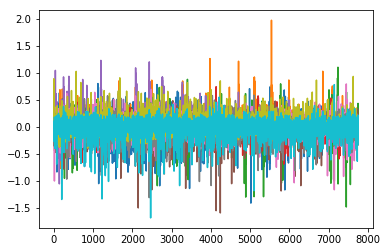

In [278]:
plt.plot(Y)

In [2]:
centroids = np.loadtxt('\\\\anastasia\\data\\2p\\kelly\\OA27\\OA27_centroids.txt', delimiter=' ')

In [4]:
mouse = 'OA27'
sort_ensemble, cell_ids, cell_clusters = cas.load.groupday_tca_model(
        mouse=mouse,
        trace_type='zscore_day',
        method='ncp_hals',
        cs='',
        warp=False,
        rank=15,
        word='bookmarks',
        group_by='all3',
        nan_thresh=0.95,
        score_threshold=0.8,
        full_output=True,
        unsorted=False,
        verbose=False)

In [5]:
rank_num = 10
drop_comp = 1000
xlist = []
ylist = []
cluslist = []

supcomp = 8
standin = 888

the_big_cluster = sort_ensemble.results[10][0].factors[0][:, supcomp]
std1 = np.std(sort_ensemble.results[10][0].factors[0][:, supcomp])*5
ablated_clus = deepcopy(cell_clusters[rank_num])
ablated_clus[(the_big_cluster < std1) & (ablated_clus == supcomp)] = standin

for cell_n in range(len(cell_ids[rank_num])):
    x, y = centroids[cell_ids[rank_num][cell_n], :]
    xlist.append(x)
    ylist.append(y*-1) # flip to match the way images are plotted
#     cluslist.append(cell_clusters[rank_num][cell_n])
    cluslist.append(ablated_clus[cell_n])
# huelist = ['component {}'.format(s + 1) for s in cluslist if s != drop_comp]
# xlist = np.array(xlist)[np.array(cluslist) != drop_comp].flatten()
# ylist = np.array(ylist)[np.array(cluslist) != drop_comp].flatten()
# huelist = ['component {}'.format(s + 1) for s in cluslist if np.isin(s, [supcomp, standin])]
huelist = ['above threshold cell' if s == supcomp else 'below threshold cell' for s in np.array(cluslist)[np.isin(np.array(cluslist), [supcomp, standin])]]
xlist = np.array(xlist)[np.isin(np.array(cluslist),  [supcomp, standin])].flatten()
ylist = np.array(ylist)[np.isin(np.array(cluslist),  [supcomp, standin])].flatten()

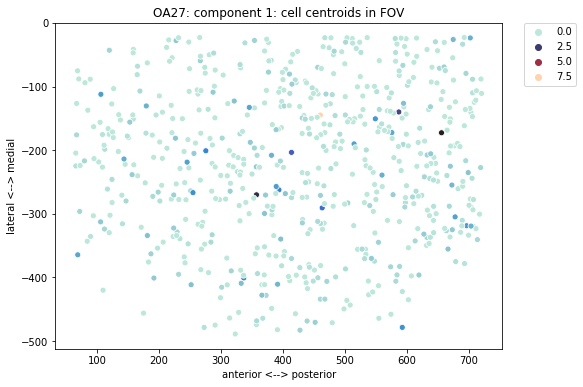

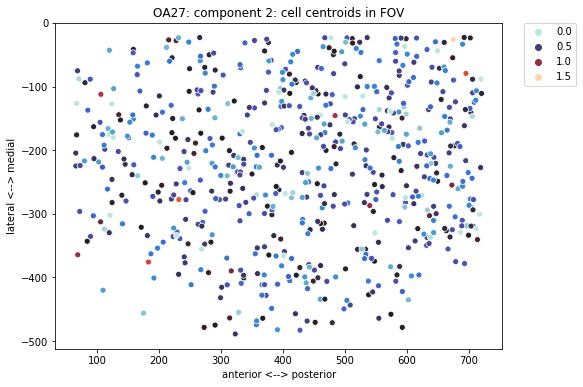

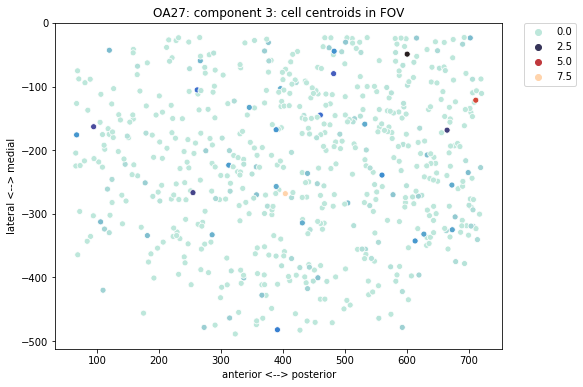

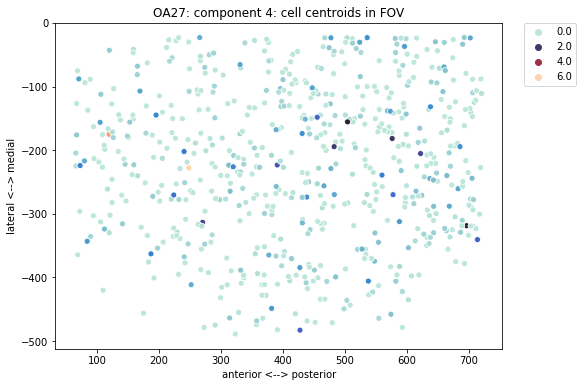

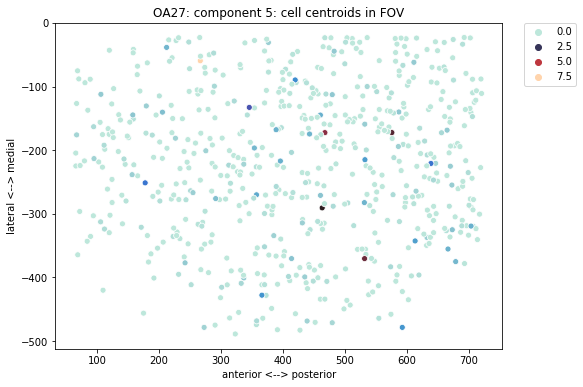

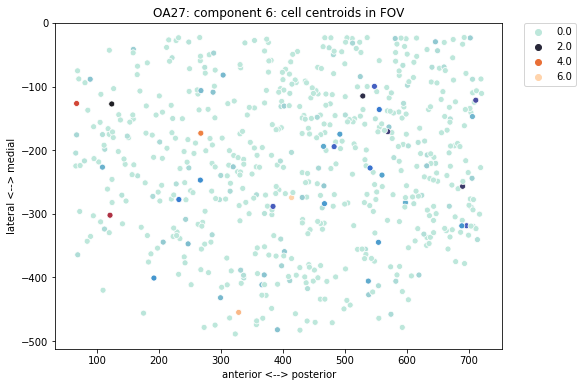

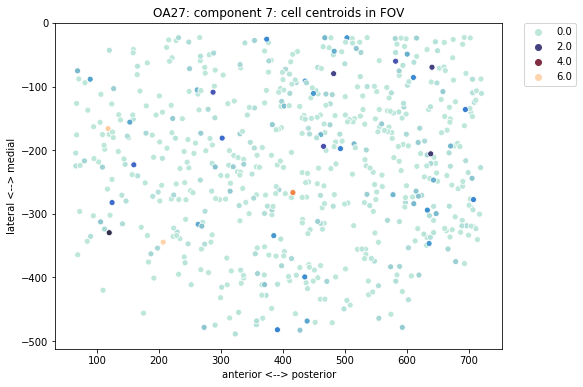

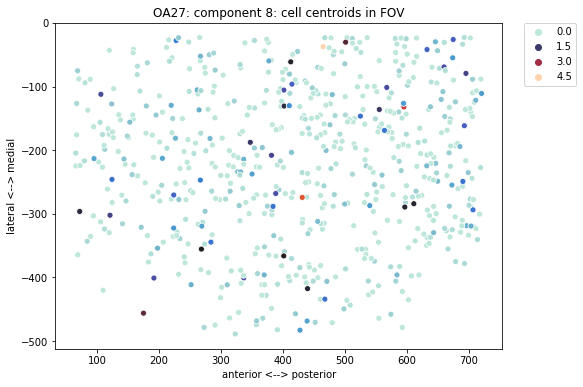

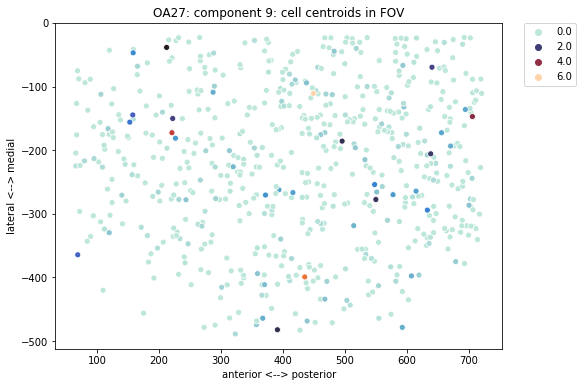

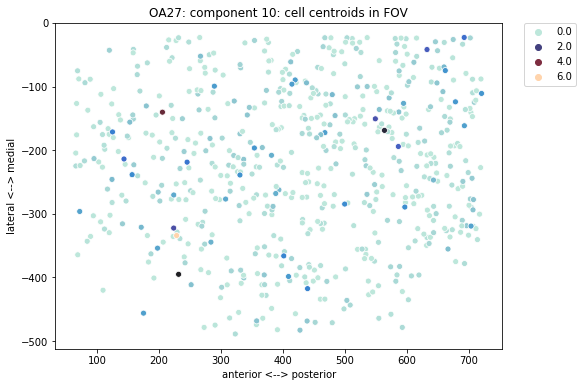

In [44]:
xlist = []
ylist = []
rank_num = 10

for cell_n in range(len(cell_ids[rank_num])):
    x, y = centroids[cell_ids[rank_num][cell_n], :]
    xlist.append(x)
    ylist.append(y*-1) # flip to match the way images are plotted
    


for compi in range(rank_num):

    hue = sort_ensemble.results[rank_num][0].factors[0][:, compi]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=xlist, y=ylist, hue=hue, palette='icefire')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(f'{mouse}: component {compi+1}: cell centroids in FOV')
    plt.ylabel('lateral <--> medial')
    plt.xlabel('anterior <--> posterior')

In [6]:
cmap = sns.color_palette('muted', int(np.ceil(rank_num/2)))
cmap.extend(sns.color_palette('dark', int(np.floor(rank_num/2))))

Text(0.5, 0, 'anterior <--> posterior')

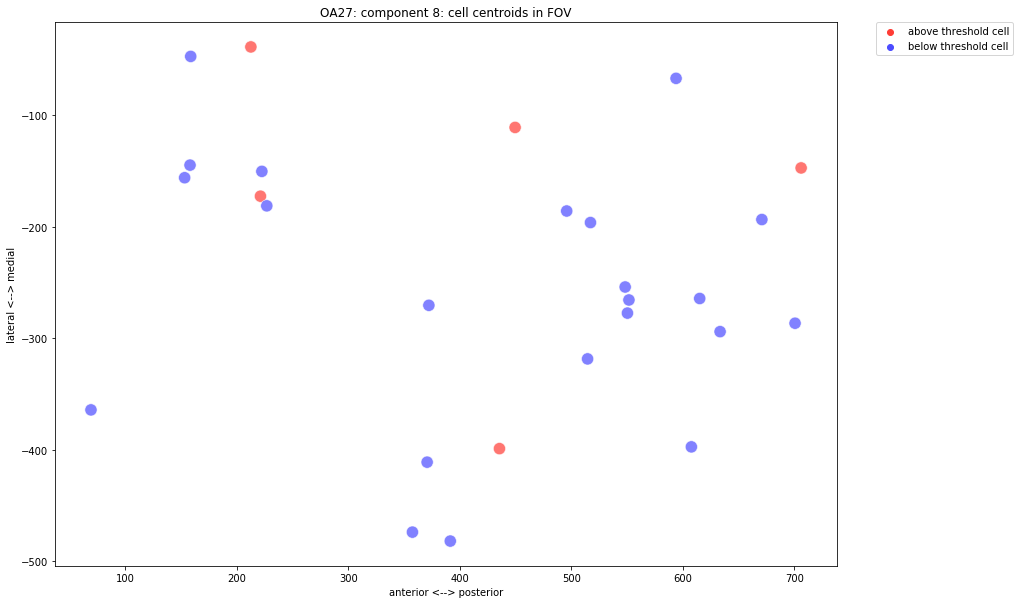

In [7]:
nclus = len(np.unique(huelist))
cmap = sns.color_palette('pastel', int(np.ceil(nclus/2)))
cmap.extend(sns.color_palette('dark', int(np.floor(nclus/2))))
#ff3c35
# hue_order = {'above threshold cell': '#ffa64c', 'below threshold cell': '#4c4cff'}
hue_order = {'above threshold cell': '#ff3c35', 'below threshold cell': '#4c4cff'}

plt.figure(figsize=(14, 10))
sns.scatterplot(x=xlist, y=ylist, alpha=0.7, s=150, hue=huelist, palette=hue_order) #palette=cmap)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(f'{mouse}: component {supcomp}: cell centroids in FOV')
plt.ylabel('lateral <--> medial')
plt.xlabel('anterior <--> posterior')

In [ ]:
# plt.figure(figsize=(14, 10))
cmap = sns.color_palette('muted', int(np.ceil(rank_num/2)))
cmap.extend(sns.color_palette('dark', int(np.floor(rank_num/2))))
for c, clus in enumerate(np.unique(cluslist)):
    x = xlist[np.array(cluslist).flatten() == clus]
    y = ylist[np.array(cluslist).flatten() == clus]
    g = sns.JointGrid(x=x, y=y,)
    g.plot_joint(sns.scatterplot, alpha=0.7, s=150, color=cmap[c])
    g.plot_marginals(sns.distplot, hist=False, color=cmap[c])

In [ ]:
# plt.figure(figsize=(14, 10))
cmap = sns.color_palette('muted', int(np.ceil(rank_num/2)))
cmap.extend(sns.color_palette('dark', int(np.floor(rank_num/2))))
for c, clus in enumerate(np.unique(cluslist)):
    x = xlist[np.array(cluslist).flatten() == clus]
    y = ylist[np.array(cluslist).flatten() == clus]
    g = sns.JointGrid(x=x, y=y,)
    g.plot_joint(sns.scatterplot, alpha=0.7, s=150, color=cmap[c])
    g.plot_marginals(sns.distplot, hist=False, color=cmap[c])

In [ ]:
cluslist

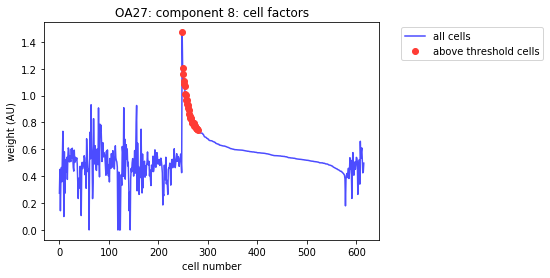

In [113]:
plt.plot(sort_ensemble.results[10][0].factors[0][:, 8], color='#4c4cff', label='all cells');
# std1 = np.std(sort_ensemble.results[10][0].factors[0][:, 8])*4
this_clus = np.isin(np.array(cluslist),  [supcomp, standin])

y_ax = sort_ensemble.results[10][0].factors[0][:, 8]
x_ax = np.arange(sort_ensemble.results[10][0].factors[0][:, 8].shape[0])
plt.plot(x_ax[(y_ax > std1) & this_clus],
         y_ax[(y_ax > std1) & this_clus],
         'o', label='above threshold cells', color='#ff3c35', ) # color='#ffa64c')
plt.title(f'{mouse}: component {supcomp}: cell factors')
plt.xlabel('cell number')
plt.ylabel('weight (AU)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

(-512, 0)

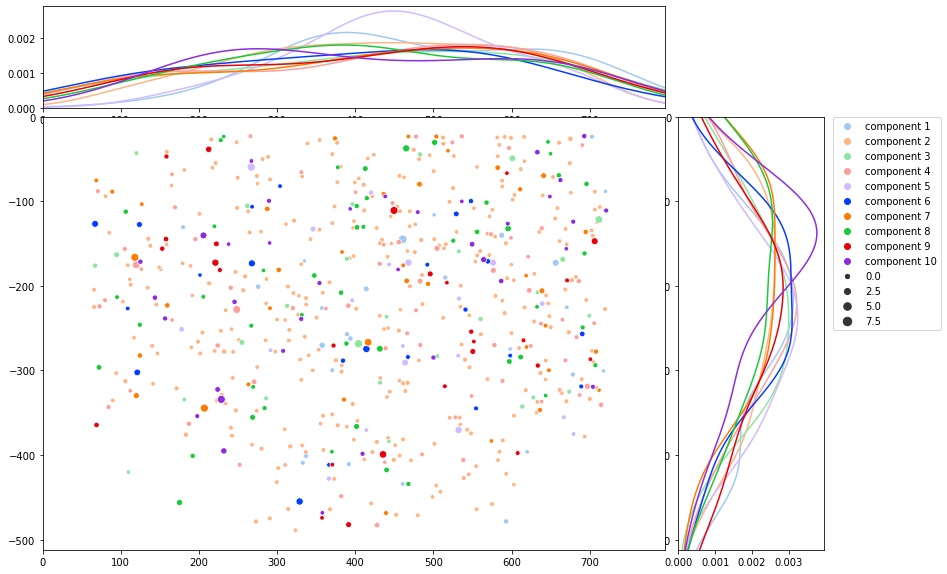

In [54]:
rank_num = 10
drop_comp = 90
xlist = []
ylist = []
cluslist = []
weightlist = []
for cell_n in range(len(cell_ids[rank_num])):
    x, y = centroids[cell_ids[rank_num][cell_n], :]
    xlist.append(x)
    ylist.append(y*-1) # flip to match the way images are plotted
    cluslist.append(cell_clusters[rank_num][cell_n] + 1)
    weightlist.append(sort_ensemble.results[rank_num][0].factors[0][cell_n, cell_clusters[rank_num][cell_n]])
# estimate drop group
# drop_comp = np.argmax([np.sum(cluslist == s) for s in np.unique(cluslist)]) + 1
huelist = ['component {}'.format(s) for s in cluslist if s != drop_comp]
xlist = np.array(xlist)[np.array(cluslist) != drop_comp].flatten()
ylist = np.array(ylist)[np.array(cluslist) != drop_comp].flatten()
weightlist = np.array(weightlist)[np.array(cluslist) != drop_comp].flatten()
cluslist = np.array(cluslist)[np.array(cluslist) != drop_comp].flatten()


# set colormap
nclus = len(np.unique(huelist))
cmap = sns.color_palette('pastel', int(np.ceil(nclus/2)))
cmap.extend(sns.color_palette('bright', int(np.floor(nclus/2))))

# create axes
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(10, 10)
ax1 = fig.add_subplot(gs[:2, :8])
ax2 = fig.add_subplot(gs[2:, 8:])
ax3 = fig.add_subplot(gs[2:, :8], sharex=ax1, sharey=ax2)

# plot x axis kde
for c, clus in enumerate(np.unique(cluslist)):
    x = xlist[np.array(cluslist).flatten() == clus]
    sns.distplot(x, ax=ax1, color=cmap[c], hist=False)

# plot y axis kde
for c, clus in enumerate(np.unique(cluslist)):
    y = ylist[np.array(cluslist).flatten() == clus]
    sns.distplot(y, ax=ax2, color=cmap[c], hist=False, vertical=True)

# plot centroid scatterplot
sns.scatterplot(x=xlist, y=ylist, alpha=1, s=150, hue=huelist, size=weightlist, palette=cmap, ax=ax3)
ax3.legend(bbox_to_anchor=(1.27, 1), loc=2, borderaxespad=0.)
ax3.set_xlim([0, 796])
ax3.set_ylim([-512, 0])

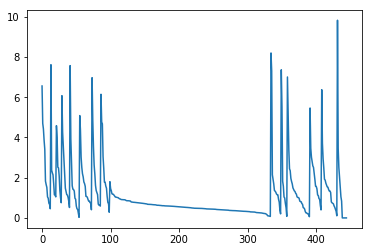

In [230]:
plt.plot(weightlist)

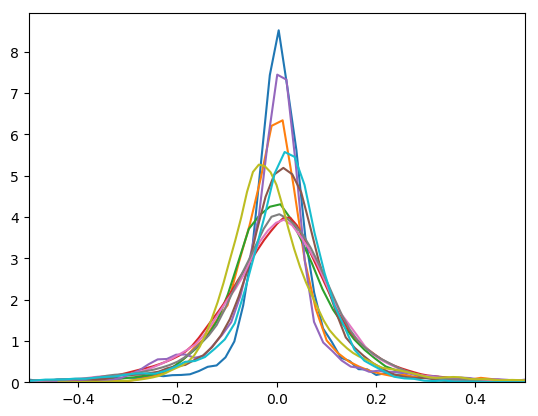

In [34]:
for i in range(Y.shape[1]):
    sns.distplot(Y[:, i], bins=50, rug=False, hist=False)
plt.xlim([-0.5, 0.5])
plt.show()

In [ ]:
# first define the ratios
r1 = 0.2       # 20%
r2 = r1 + 0.4  # 40%

# define some sizes of the scatter marker
sizes = np.array([60, 80, 120])

# calculate the points of the first pie marker
#
# these are just the origin (0,0) +
# some points on a circle cos,sin
x = [0] + np.cos(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * r1, 10)).tolist()
xy1 = np.column_stack([x, y])
s1 = np.abs(xy1).max()

x = [0] + np.cos(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r1, 2 * np.pi * r2, 10)).tolist()
xy2 = np.column_stack([x, y])
s2 = np.abs(xy2).max()

x = [0] + np.cos(np.linspace(2 * np.pi * r2, 2 * np.pi, 10)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * r2, 2 * np.pi, 10)).tolist()
xy3 = np.column_stack([x, y])
s3 = np.abs(xy3).max()

fig, ax = plt.subplots()
ax.scatter(range(3), range(3), marker=(xy1, 0),
           s=s1 ** 2 * sizes, facecolor='blue')
ax.scatter(range(3), range(3), marker=(xy2, 0),
           s=s2 ** 2 * sizes, facecolor='green')
ax.scatter(range(3), range(3), marker=(xy3, 0),
           s=s3 ** 2 * sizes, facecolor='red')

plt.show()

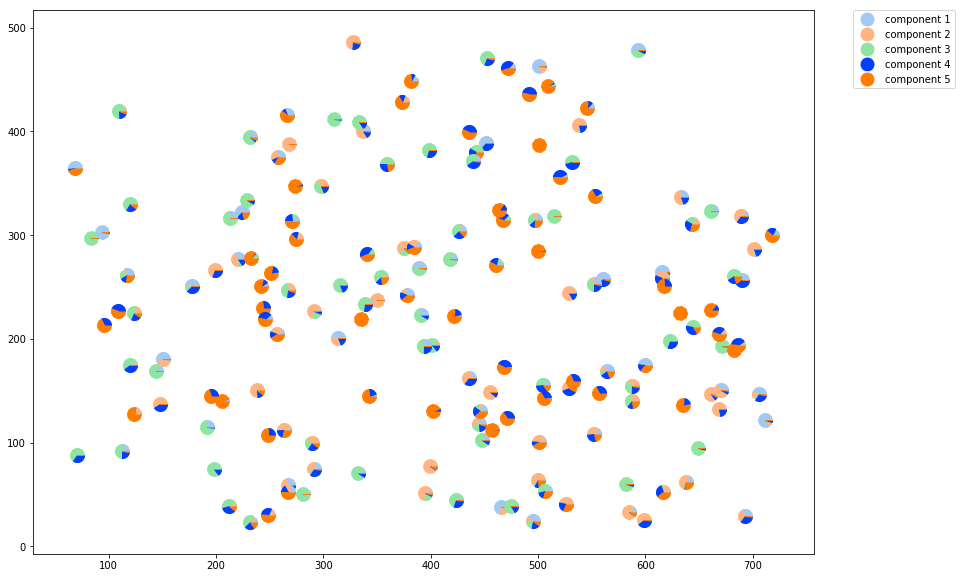

In [274]:
from matplotlib.lines import Line2D
sizes = 200
rank_num = 5
skip_comp = 4
fig, ax = plt.subplots(figsize=(14,10))
# set colormap
nclus = rank_num
cmap = sns.color_palette('pastel', int(np.ceil(nclus/2)))
cmap.extend(sns.color_palette('bright', int(np.floor(nclus/2))))
leg_n = 0
leg_done = False
for cell_n in range(len(cell_ids[rank_num])):
    if cell_clusters[rank_num][cell_n] + 1 == skip_comp:
        if leg_done == False:
            leg_n = leg_n + 1
        continue
    x, y = centroids[cell_ids[rank_num][cell_n], :]
#     r = {}
    slices = []
    r0 = 0
    r1 = 0
    for r_n in range(rank_num):
        total = np.sum(sort_ensemble.results[rank_num][0].factors[0][cell_n, :])
        r = sort_ensemble.results[rank_num][0].factors[0][cell_n, r_n]/total
        r1 = r1 + r
        rx = [0] + np.cos(np.linspace(2 * np.pi * r0, 2 * np.pi * r1, 10)).tolist()
        ry = [0] + np.sin(np.linspace(2 * np.pi * r0, 2 * np.pi * r1, 10)).tolist()
        r0 = r0 + r
        slice1 = np.column_stack([rx, ry])
        slices.append(slice1)
        s1 = np.abs(slice1).max()
#         if cell_n == leg_n:
#             ax.scatter(x, y, marker=(slice1, 0),
#                    s= 1 * sizes, facecolor=cmap[r_n], alpha=0.7, label='component {}'.format(r_n + 1))
#             leg_done = True
#         else:
        ax.scatter(x, y, marker=(slice1, 0),
               s= s1 ** 4 * sizes, facecolor=cmap[r_n], alpha=1)
cus_leg = []
for r_n in range(rank_num):
    cus_leg.append(Line2D([0], [0], marker='o', color='w', label='component {}'.format(r_n + 1), markerfacecolor=cmap[r_n], markersize=15))
plt.legend(handles=cus_leg, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)